# OLYMPIC GAMES DATA EXPLORATION

In [22]:
from mysecrets import pw
import functions

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [23]:
# Let's directly connect to our MySQL Database that contains the already processed and usable data.
connection = functions.create_db_connection("localhost", "root", pw, "ProcessedSportsStats")

MySQL Database connection successful


In [24]:
# Set style
sns.set_style('whitegrid')
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (9, 5)

### EXPLORATION ABOUT AGE OF MEDALISTS

In [25]:
query = """SELECT *
    FROM Events;"""
events_df = pd.read_sql(query, connection, index_col=['EventId'])

events_df.head()


/var/folders/q3/qxmx6rxn2xjcrqr620k0l4_c0000gn/T/ipykernel_30694/1777497206.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  events_df = pd.read_sql(query, connection, index_col=['EventId'])


,AthleteId,Age,Team,NOC,Games,Category,Medal
EventId,,,,,,,
1,1,24.0,China,CHN,1992 Summer,Basketball Men's Basketball,None
2,2,23.0,China,CHN,2012 Summer,Judo Men's Extra-Lightweight,None
3,3,24.0,Denmark,DEN,1920 Summer,Football Men's Football,None
4,4,34.0,Denmark/Sweden,DEN,1900 Summer,Tug-Of-War Men's Tug-Of-War,Gold
5,5,21.0,Netherlands,NED,1988 Winter,Speed Skating Women's 500 metres,None


In [26]:
medalists_df = events_df[~events_df['Medal'].isnull()]
medalists_df

,AthleteId,Age,Team,NOC,Games,Category,Medal
EventId,,,,,,,
4,4,34.0,Denmark/Sweden,DEN,1900 Summer,Tug-Of-War Men's Tug-Of-War,Gold
38,15,30.0,Finland,FIN,1920 Summer,Swimming Men's 200 metres Breaststroke,Bronze
39,15,30.0,Finland,FIN,1920 Summer,Swimming Men's 400 metres Breaststroke,Bronze
41,16,28.0,Finland,FIN,2014 Winter,Ice Hockey Men's Ice Hockey,Bronze
42,17,28.0,Finland,FIN,1948 Summer,Gymnastics Men's Individual All-Around,Bronze
...,...,...,...,...,...,...,...
271079,135553,25.0,Soviet Union,URS,1956 Summer,Athletics Women's Shot Put,Silver
271081,135553,33.0,Soviet Union,URS,1964 Summer,Athletics Women's Shot Put,Bronze
271083,135554,28.0,Poland,POL,1980 Summer,"Fencing Men's Foil, Team",Bronze


In [27]:
medalists_df['Age'].max()

73.0

In [28]:
medalists_df['Age'].min()

10.0

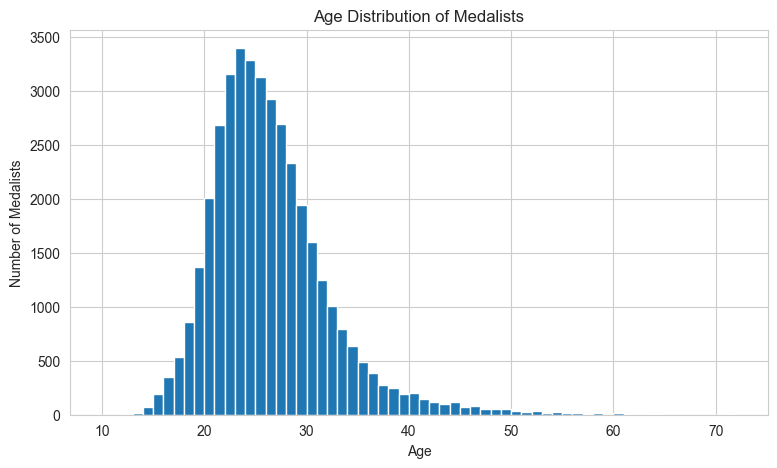

In [29]:
# Find how many medalists we encounter for each AGE group and visualise it
plt.title('Age Distribution of Medalists')
plt.xlabel('Age')
plt.ylabel('Number of Medalists')

plt.hist(medalists_df.Age, bins=np.arange(10,73,1));

It makes sense most medalist's ages range in between 20 and 30. In particular, the descriptive stats are:

In [30]:
medalists_df['Age'].describe()

count    39051.000000
mean        25.925175
std          5.914026
min         10.000000
25%         22.000000
50%         25.000000
75%         29.000000
max         73.000000
Name: Age, dtype: float64

I am now interested in knowing the mean of medalists in different sports. That is, if the best age for sports performance varies depending on the sport.

In [31]:
query = """SELECT *
    FROM Categories;"""
categories_df = pd.read_sql(query, connection)

categories_df.head()

/var/folders/q3/qxmx6rxn2xjcrqr620k0l4_c0000gn/T/ipykernel_30694/2678237404.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  categories_df = pd.read_sql(query, connection)


,Category,Sport
0,Aeronautics Mixed Aeronautics,Aeronautics
1,Alpine Skiing Men's Combined,Alpine Skiing
2,Alpine Skiing Men's Downhill,Alpine Skiing
3,Alpine Skiing Men's Giant Slalom,Alpine Skiing
4,Alpine Skiing Men's Slalom,Alpine Skiing


Sport
Roque                        53.333333
Art Competitions             42.328947
Alpinism                     38.812500
Equestrianism                35.371728
Polo                         34.584615
                               ...    
Boxing                       23.058002
Short Track Speed Skating    22.429577
Diving                       22.264775
Swimming                     20.923356
Rhythmic Gymnastics          18.931818
Name: Age, Length: 66, dtype: float64

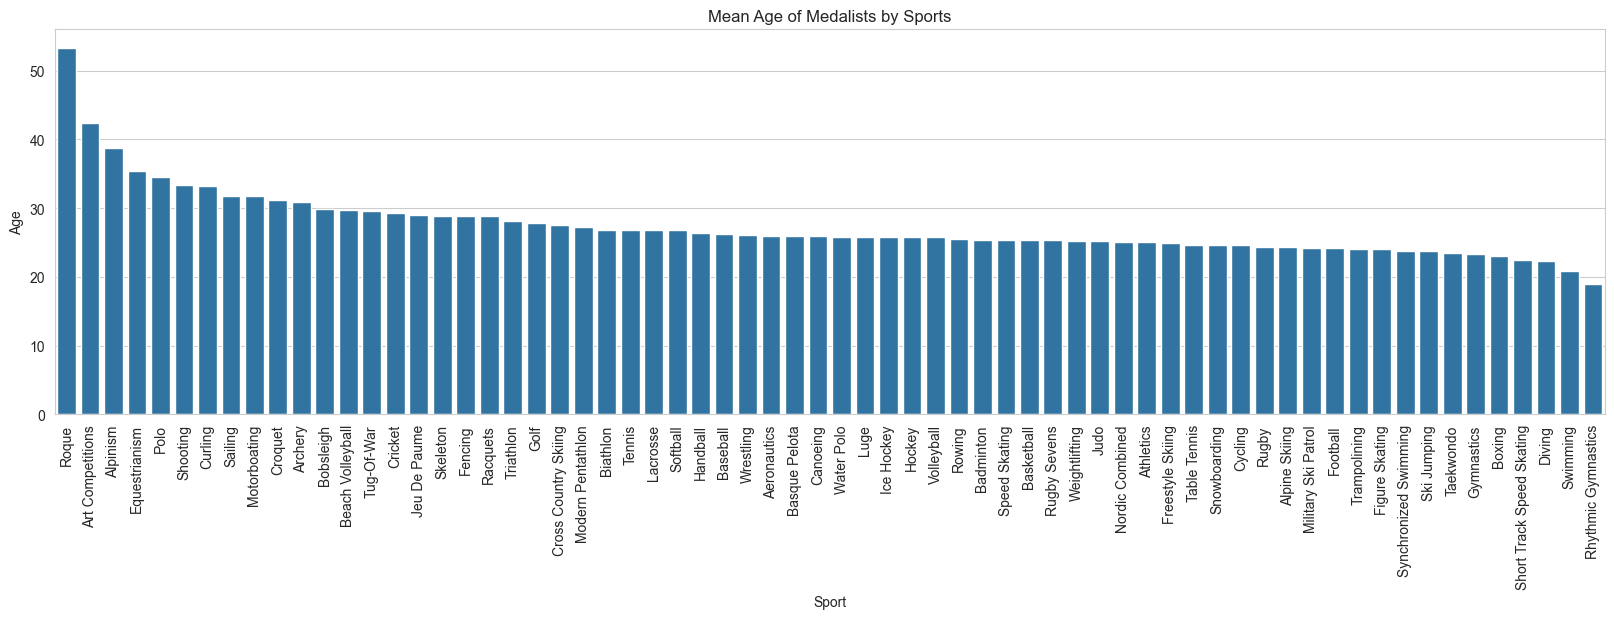

In [68]:
age_grouped_sports_df = medalists_df.merge(categories_df, on='Category', how='left').groupby("Sport")["Age"].mean().sort_values(ascending=False)
matplotlib.rcParams['figure.figsize'] = (20, 5)
plt.xticks(rotation=90)
plt.title('Mean Age of Medalists by Sports')
sns.barplot(x=age_grouped_sports_df.index, y=age_grouped_sports_df);

age_grouped_sports_df


### EXPLORATION ABOUT SPORT-REGION RELATION

In [33]:
query = """SELECT *
    FROM NOC
    WHERE Region IS NOT NULL;"""
noc_df = pd.read_sql(query, connection)

noc_df

/var/folders/q3/qxmx6rxn2xjcrqr620k0l4_c0000gn/T/ipykernel_30694/824951885.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  noc_df = pd.read_sql(query, connection)


,NOC,Region,Notes
0,AFG,Afghanistan,None
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,None
3,ALG,Algeria,None
4,AND,Andorra,None
...,...,...,...
219,YEM,Yemen,None
220,YMD,Yemen,South Yemen
221,YUG,Serbia,Yugoslavia
222,ZAM,Zambia,None


In [34]:
# merge as to have region and sport in the row of each event.
sport_region_df = medalists_df.merge(categories_df, on='Category', how='left').merge(noc_df[['NOC','Region']], on='NOC')

# Now, let's count a Gold medal as 3 points, Silver as 2 and Bronze as 1 (as to add value to the medals)
sport_region_df.loc[sport_region_df["Medal"] == "Gold", "Medal"] = 3
sport_region_df.loc[sport_region_df["Medal"] == "Silver", "Medal"] = 2
sport_region_df.loc[sport_region_df["Medal"] == "Bronze", "Medal"] = 1

# Now, group by Sport and country and sum the points they have
sport_region_df = sport_region_df.groupby(["Region", "Sport"]).agg(Points = ('Medal', 'sum')).sort_values(by=['Points'], ascending=False)

# And now we are just interested to show per region, the sport that has max points
idx = sport_region_df.groupby("Region")['Points'].transform(max) == sport_region_df['Points']
sport_region_df = sport_region_df[idx].reset_index()	
sport_region_df.head(50)

/var/folders/q3/qxmx6rxn2xjcrqr620k0l4_c0000gn/T/ipykernel_30694/782644863.py:13: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = sport_region_df.groupby("Region")['Points'].transform(max) == sport_region_df['Points']


,Region,Sport,Points
0,USA,Swimming,2630
1,Germany,Rowing,1107
2,Russia,Gymnastics,893
3,Canada,Ice Hockey,881
4,Australia,Swimming,823
5,Italy,Fencing,797
6,France,Fencing,660
7,UK,Athletics,627
8,Netherlands,Hockey,502
9,Hungary,Fencing,502


In [35]:
# And now a bit of exploration over this:
sport_region_df[(sport_region_df['Sport'] == "Ice Hockey") | (sport_region_df['Sport'] == "Cross Country Skiing") | (sport_region_df['Sport'] == "Alpine Skiing")]

,Region,Sport,Points
3,Canada,Ice Hockey,881
11,Sweden,Ice Hockey,381
13,Norway,Cross Country Skiing,345
17,Czech Republic,Ice Hockey,300
24,Austria,Alpine Skiing,221
74,Liechtenstein,Alpine Skiing,15


It makes sense all these countries whose best sport is something ice-skiing related are cold countries, and weather and culture helps.

In [36]:
sport_region_df[sport_region_df['Sport'] == 'Athletics']

,Region,Sport,Points
7,UK,Athletics,627
15,Finland,Athletics,308
16,Jamaica,Athletics,307
25,Kenya,Athletics,205
30,Poland,Athletics,154
37,Ethiopia,Athletics,106
41,Bahamas,Athletics,71
43,South Africa,Athletics,64
46,Trinidad,Athletics,54
55,Morocco,Athletics,36


In [37]:
sport_region_df[sport_region_df['Sport'] =='Football']

,Region,Sport,Points
28,Argentina,Football,170
38,Nigeria,Football,98
39,Uruguay,Football,93
45,Cameroon,Football,54
47,Mexico,Football,48
57,Paraguay,Football,34
70,Ghana,Football,20
73,Chile,Football,17


### EXPLORATION ABOUR BMI(Body Mass Index)-SPORT RELATION

We first need to add a new metric (specifically a new column) to our athletes table to calculate the BMI of those records for which height and weight fields are not null. 

In [42]:
query = """SELECT AthleteId, Height, Weight
    FROM Athletes
    WHERE Weight IS NOT NULL AND Height IS NOT NULL;"""
bmi_df = pd.read_sql(query, connection)

bmi_df['BMI'] = bmi_df['Weight'] / pow(bmi_df['Height']/100,2)

bmi_df.head()

/var/folders/q3/qxmx6rxn2xjcrqr620k0l4_c0000gn/T/ipykernel_30694/293275916.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bmi_df = pd.read_sql(query, connection)


,AthleteId,Height,Weight,BMI
0,1,180,80,24.691358
1,2,170,60,20.761246
2,5,185,82,23.959094
3,6,188,75,21.220009
4,7,183,72,21.499597


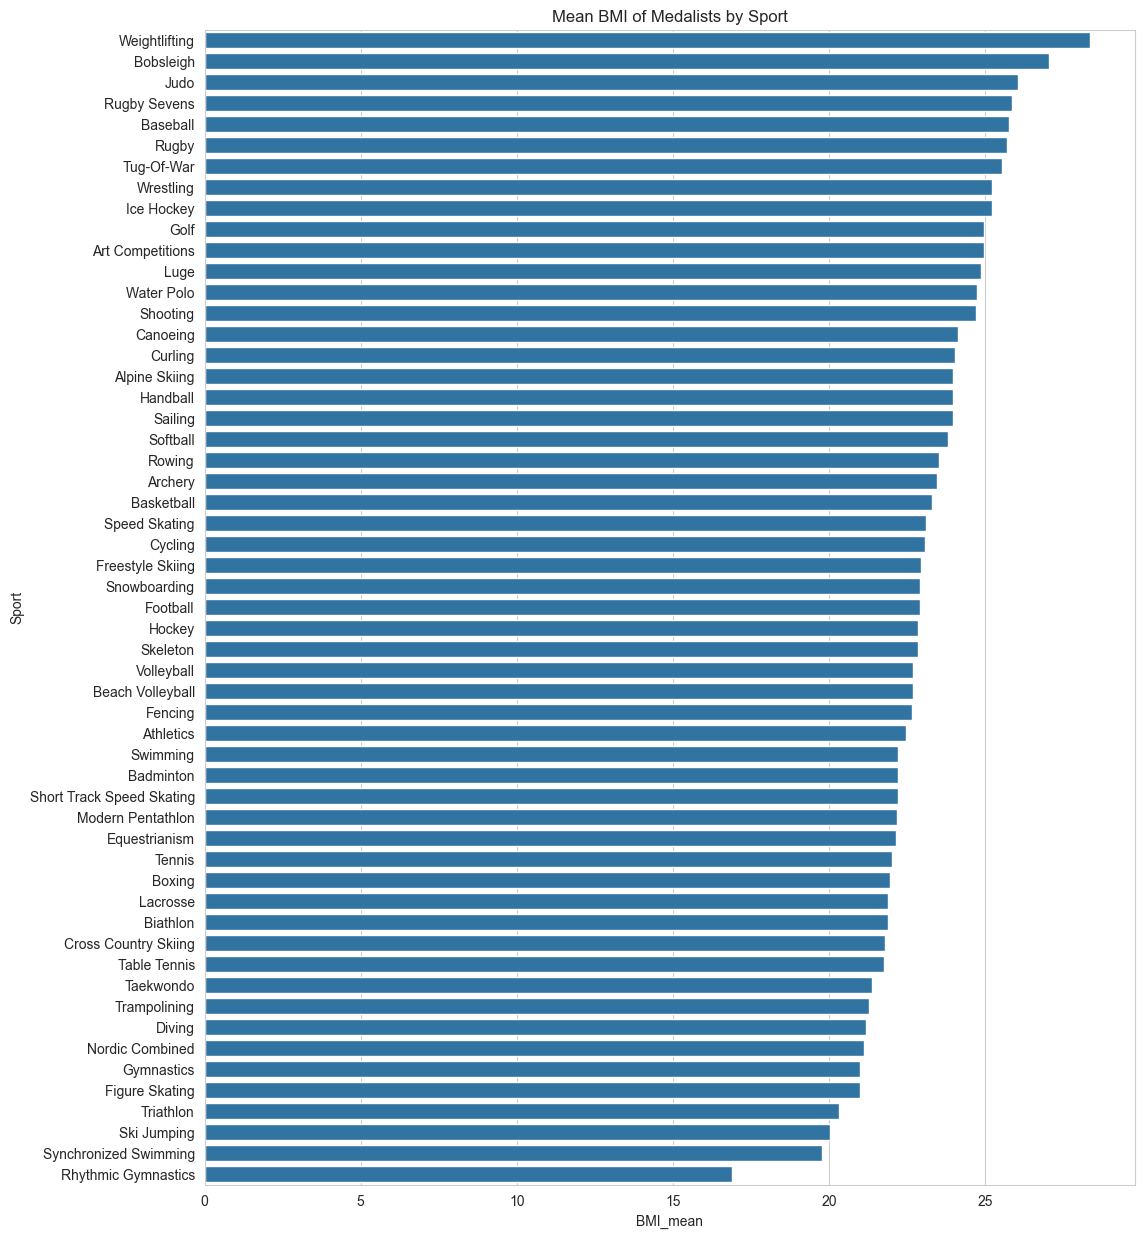

In [82]:
# merge as to have BMI and sport in the row of each event. (Only considering athletes that have info about their BMI, so weight and height were not null)
bmi_sport_df = medalists_df.merge(bmi_df[['AthleteId','BMI']], on='AthleteId', how='right').merge(categories_df, on='Category')

bmi_sport_df = bmi_sport_df.groupby(["Sport"]).agg(BMI_mean = ('BMI', 'mean')).sort_values(by=['BMI_mean'], ascending=False)
bmi_sport_df

matplotlib.rcParams['figure.figsize'] = (12, 15)
plt.title('Mean BMI of Medalists by Sport')
sns.barplot(y=bmi_sport_df.index, x=bmi_sport_df['BMI_mean'], orient='h');
